<a href="https://colab.research.google.com/github/lordoz234/ML_Homework/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook  
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"lordozvlad","key":"fe816606c5617e40ec838a122df91cae"}'}

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c advanced-dls-spring-2021

submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

'kaggle (1).json'   sample_data      test.csv
 kaggle.json	    submission.csv   train.csv


In [8]:
data = pd.read_csv("train.csv")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
data['TotalSpent'] = data['TotalSpent'].where(data['ClientPeriod'] > 0, data['MonthlySpending'])
data['ClientPeriod'] = data['ClientPeriod'].where(data['ClientPeriod'] > 0, 1)
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

In [11]:
cat_cols = [x for x in data.columns if data[x].dtype == 'object']
num_cols = [x for x in data.columns if data[x].dtype in ['int64', 'float64'] and x != 'Churn']
target_col = "Churn"
print("Категориальные признаки: ", ", ".join(cat_cols))
print("Числовые признаки: ", ", ".join(num_cols))
print("Целевой признак: ", target_col)

Категориальные признаки:  Sex, HasPartner, HasChild, HasPhoneService, HasMultiplePhoneNumbers, HasInternetService, HasOnlineSecurityService, HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasOnlineTV, HasMovieSubscription, HasContractPhone, IsBillingPaperless, PaymentMethod
Числовые признаки:  ClientPeriod, MonthlySpending, TotalSpent, IsSeniorCitizen
Целевой признак:  Churn


In [129]:
from sklearn.preprocessing import MaxAbsScaler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_transform = Pipeline(steps=[
                    ('scale', MaxAbsScaler())                             
])
cat_transfrom = Pipeline(steps=[
                    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
                    ('scale', MaxAbsScaler())
])

In [130]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(transformers = [
                                    ('cat', cat_transfrom, cat_cols),
                                    ('num', num_transform, num_cols)
])

In [258]:
train_data, train_target = data.drop(['Churn'], axis = 1), data['Churn']
train_data = preprocessing.fit_transform(train_data)
train_target = train_target.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size = 0.2, random_state = 42)

In [250]:
from sklearn.metrics import accuracy_score

def score(output, y):
    x = output > 0.5
    a = []
    for i in x:
        if i == True:
            a.append(1)
        else:
            a.append(0)

    return accuracy_score(y.detach().numpy(), a)

In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

EPOCHS = 100

ac_neurons   = []
ac_val_neurons = []
loss_neurons = []
loss_valid_neurons = []

X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))

array = np.arange(2, 400, 10)

for neurons in array:
    model = nn.Sequential(
        nn.Linear(45, neurons),
        nn.ReLU(),
        nn.Linear(neurons, 1),
        nn.Sigmoid()
    )

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    train_losses = []
    val_losses   = []

    ac_train_score = []
    ac_val_score   = []

    scores = 0

    for ep in range(EPOCHS):
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        outputs_valid = model(X_valid)
        loss_valid = criterion(outputs_valid, y_valid)

        ac_train_score.append(score(outputs, y_train))
        ac_val_score.append(score(outputs_valid, y_valid))

        scores += score(outputs_valid, y_valid)

        train_losses.append(loss.item())
        val_losses.append(loss_valid.item())
    
    ac_neurons.append(np.mean(ac_train_score))
    ac_val_neurons.append(np.mean(ac_val_score))
    loss_neurons.append(np.mean(train_losses))
    loss_valid_neurons.append(np.mean(val_losses))

In [252]:
diff = []

for i in range(len(ac_neurons)):
    diff.append(train_losses[i] - val_losses[i])

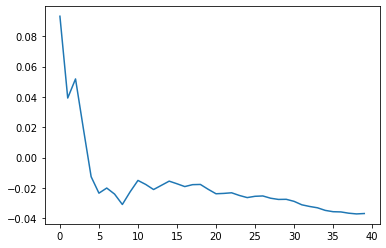

In [256]:
plt.plot(diff)
pass

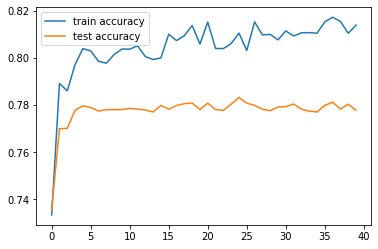

In [254]:
plt.plot(ac_neurons, label='train accuracy')
plt.plot(ac_val_neurons, label='test accuracy')
plt.legend()
plt.show()

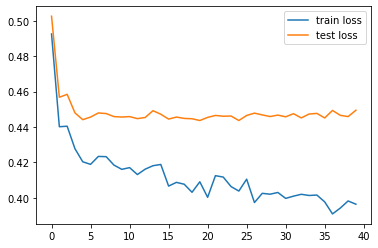

In [255]:
plt.plot(loss_neurons, label='train loss')
plt.plot(loss_valid_neurons, label='test loss')
plt.legend()
plt.show()

In [257]:
array[5]

52

Как видно из графика, оптимальное количество нейронов - 5 значение в массиве array = 52 

Также можно заметить, что после 52 нейронов наблюдается переобучение (значение для валидационной остается практически неизменной, а значение на тренировочной уменьшается и разница увеличивается с увелиением количеством нейронов)

In [267]:
train_data, train_target = data.drop(['Churn'], axis = 1), data['Churn']
train_data = preprocessing.fit_transform(train_data)
train_target = train_target.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size = 0.2, random_state = 42)

In [268]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

EPOCHS = 100

ac_neurons   = []
ac_val_neurons = []
loss_neurons = []
loss_valid_neurons = []

X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))

learning_rate = np.logspace(-4, 1, 20)

for lr in learning_rate:
    model = nn.Sequential(
        nn.Linear(45, 52),
        nn.ReLU(),
        nn.Linear(52, 1),
        nn.Sigmoid()
    )

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_losses = []
    val_losses   = []

    ac_train_score = []
    ac_val_score   = []

    scores = 0

    for ep in range(EPOCHS):
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        outputs_valid = model(X_valid)
        loss_valid = criterion(outputs_valid, y_valid)

        ac_train_score.append(score(outputs, y_train))
        ac_val_score.append(score(outputs_valid, y_valid))

        scores += score(outputs_valid, y_valid)

        train_losses.append(loss.item())
        val_losses.append(loss_valid.item())
    
    ac_neurons.append(np.mean(ac_train_score))
    ac_val_neurons.append(np.mean(ac_val_score))
    loss_neurons.append(np.mean(train_losses))
    loss_valid_neurons.append(np.mean(val_losses))

In [269]:
learning_rate

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

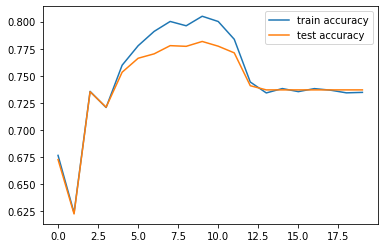

In [271]:
plt.plot(ac_neurons, label='train accuracy')
plt.plot(ac_val_neurons, label='test accuracy')
plt.legend()
plt.show()

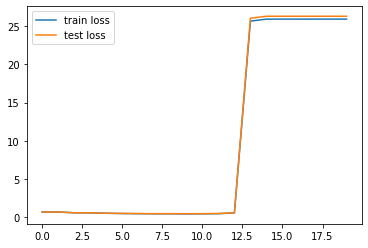

In [275]:
plt.plot(loss_neurons, label='train loss')
plt.plot(loss_valid_neurons, label='test loss')
plt.legend()
plt.show()

In [276]:
learning_rate[8]

0.012742749857031334

По графику видно, что оптимальное значение alpha - 0.013